# How to find peaks
This notebook demonstrates a quick way of finding and plotting peaks.

In the `hierarchical_peaks` software, the term 'peak' does not mean a single local maximum, it means a cluster of one or more local maxima. `PeakTree` objects have a `.maxima` method for finding local maxima, but we use their `.maxdeep` method for finding peaks.


In [1]:
import random
from itertools import accumulate

import matplotlib as mpl
import matplotlib.pyplot as plt

import ipywidgets as widget

import hierarchical_peaks as hip

%matplotlib inline
plt.style.use('seaborn-talk')


We will use this example data set:

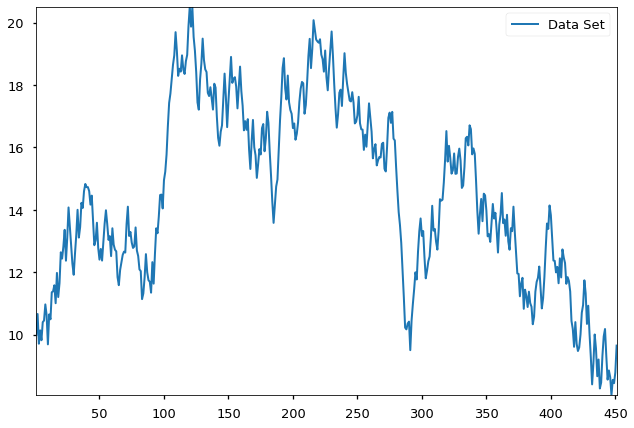

In [2]:
# Generate a synthetic data set (X, Y):

random.seed(a="It's...") # ref. Monty Python

X, Y = zip(*enumerate(accumulate((random.uniform(-1, 1) for n in range(450)), initial=10), start=1))


# plot to show all the rich peaks:

fig, ax = plt.subplots()
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.plot(X, Y, lw=2, c="C0", label="Data Set")
ax.legend();

We will follow these steps:
1. Initialize a PeakTree instance `tree` by feeding data to `hip.PeakTree`
2. Choose a value of `D_max`, which is an upper bound for the depths of peaks
3. Find a list of `peaks` using `tree.maxdeep(D_max)`
4. Convert the list of peaks to a list of points on the graph
5. Find the locations of the `peaks` using `hip.peak_locations`

In [3]:
# Step 1: Initialize a PeakTree object for the (X, Y) data set:

tree = hip.PeakTree(hip.filter_local_extrema(zip(X, Y)))

# Step 2: Choose an upper bound for depth:

D_max = 5

# Step 3: Find a sorted list of peaks:

peaks = sorted(tree.maxdeep(D_max))

print(peaks)

[3, 11, 15, 18, 86, 91, 94, 98, 143, 169, 175, 272, 290, 296, 378, 382, 393, 419, 428, 436, 444, 449]


What `maxdeep` does internally is to find all nodes `x` in the `tree` for which:
- The depth of `x` is below `D_max`
- The depth of the successor of x is above `D_max`

So the list of `peaks`could have been found by:

In [4]:
print([x for x in tree if tree.depth(x) < D_max and tree.depth(tree.successor(x)) >= D_max])

[3, 11, 15, 18, 86, 91, 94, 98, 143, 169, 175, 272, 290, 296, 378, 382, 393, 419, 428, 436, 444, 449]


Back to our practical recipe: `peaks` is a list of x-values. The corresponding points on the curve are:

In [5]:
# Step 4: Convert the list of peaks to a list of points on the graph

peakpoints = [(x, tree.elevation[x]) for x in peaks]

print(peakpoints)

[(3, 9.714388360122886), (11, 10.655184771403928), (15, 11.585963345319987), (18, 11.209898344137232), (86, 12.583843081366659), (91, 12.326826724634591), (94, 13.412429442717805), (98, 14.491952347106833), (143, 16.05697423783908), (169, 16.882113363746782), (175, 15.776694211112513), (272, 15.231949067539995), (290, 10.422451183625814), (296, 11.772632523664862), (378, 11.824870393571926), (382, 10.890425722864832), (393, 10.84487177316964), (419, 10.406141375469309), (428, 10.348695158587295), (436, 8.672442853399486), (444, 8.564564160213358), (449, 8.44985755788461)]


In [6]:
# Step 5: Find the peak locations:

location = hip.peak_locations(peakpoints, zip(X, Y))

print(location)

{449: (448, 451), 444: (440, 446), 436: (433, 437), 428: (424, 429), 419: (419, 419), 393: (388, 415), 382: (380, 385), 378: (378, 378), 296: (295, 375), 290: (290, 290), 272: (189, 280), 175: (174, 182), 169: (169, 169), 143: (103, 165), 98: (98, 98), 94: (94, 94), 91: (91, 91), 86: (86, 86), 18: (17, 82), 15: (15, 15), 11: (11, 11), 3: (1, 9)}


With this dictionary, each peak `x`has a `location[x]` which is a pair of x-values: `(x1, x2)`. `x1` is the start and `x2` is the end of the interval on the x-axis covered by the peak.

Now we have gone through the five steps to find peaks and their locations.

## Plotting

In [7]:
# plotting functions for one peak:

def add_crown(ax, x1, x2, height, depth):
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, height - depth),
                                       width=x2 - x1,
                                       height=depth,
                                       fill=True,
                                       linewidth=1,
                                       facecolor="gold",
                                       edgecolor="C2",
                                      ))

def add_pedestal(ax, x1, x2, height, depth):
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, 0),
                                       width=x2 - x1,
                                       height=height - depth,
                                       fill=True,
                                       linewidth=1,
                                       edgecolor="C2",
                                       facecolor="lavender",
                                      ))

First, we will highlight the `peaks` in the graph by drawing a yellow rectangle around each peak.

The width of the rectangle is the width of the `location` interval and the height of the rectangle is the peak's `depth`.

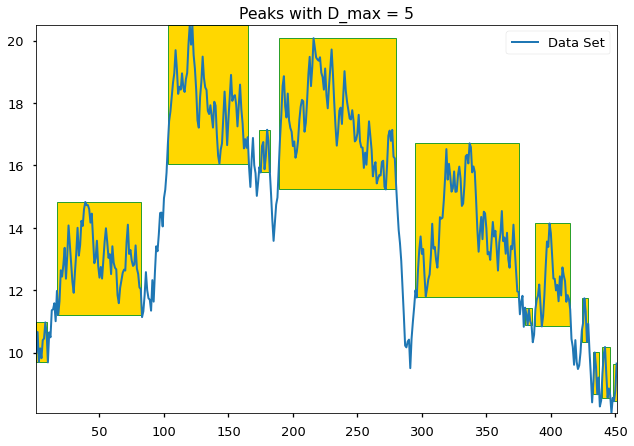

In [8]:
fig, ax = plt.subplots()
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.set_title("Peaks with D_max = 5")

for peak in peaks:
    add_crown(ax, *location[peak], tree.height(peak), tree.depth(peak))

ax.plot(X, Y, lw=2, c="C0", label="Data Set")
ax.legend();

So, we have managed to find and plot peaks!

Next, how does the `D_max` parameter determine the size of peaks? This can be explored in an interactive plot:

In [9]:
def find_and_plot_peaks(D_max):
    # find peaks and their locations:
    peaks = sorted(tree.maxdeep(D_max))
    location = hip.peak_locations([(x, tree.elevation[x]) for x in peaks], zip(X, Y))

    # make a new plot:
    fig, ax = plt.subplots()
    ax.set_xlim([min(X),max(X)])
    ax.set_ylim([min(Y),max(Y)])

    for peak in peaks:
        add_pedestal(ax, *location[peak], tree.height(peak), tree.depth(peak))
        add_crown(ax, *location[peak], tree.height(peak), tree.depth(peak))
    
    ax.plot(X, Y, lw=2, c="C0", label="Data Set")
    ax.legend();

    

widget.interact(find_and_plot_peaks,
                D_max=widget.FloatSlider(min=0,
                                         max=max(Y)-min(Y),
                                         step=0.1,
                                         value=3.0,
                                         continuous_update=False
                                        )
               );

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='D_max', max=12.449776443279…

Use the slider to change the `D_max` parameter!

By increasing the depths, the peaks become wider and they merge into even larger peaks.

At the extremes of the `D_max` range, peaks become identical to the local maxima (at `D_max = 0`), or the whole curve becomes one large peak.

Let me just verify that for `D_max = 0`:

In [12]:
sorted(tree.maxdeep(0)) == tree.maxima()

True